In [1]:
!git clone https://github.com/Jaish19/Artificial-Intelligence.git

!ls

fatal: destination path 'Artificial-Intelligence' already exists and is not an empty directory.
Artificial-Intelligence  mask_rcnn_coco.h5  sample_data


In [2]:
! pip install mrcnn

In [4]:
! pip uninstall opencv-python

Uninstalling opencv-python-3.4.0.12:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-3.4.0.12.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-3.4.0.12


In [5]:
!pip install opencv-python==3.4.0.12

  Using cached https://files.pythonhosted.org/packages/50/f9/5c454f0f52788a913979877e6ed9b2454a9c7676581a0ee3a2d81db784a6/opencv_python-3.4.0.12-cp36-cp36m-manylinux1_x86_64.whl
ERROR: dopamine-rl 1.0.5 has requirement opencv-python>=3.4.1.15, but you'll have opencv-python 3.4.0.12 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
import tensorflow
print(tensorflow.__version__)
!pip install 'tensorflow==1.14.0'
print(tensorflow.__version__)

Processing 1 images
image                    shape: (1322, 2448, 3)       min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2448.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


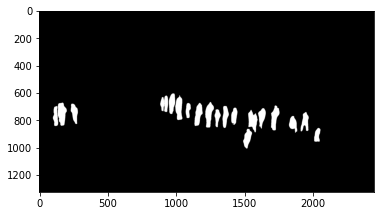

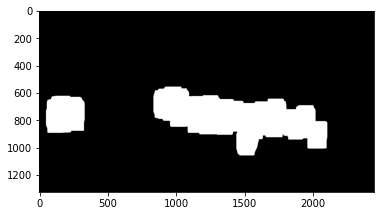

Found 18 people in line outside the building


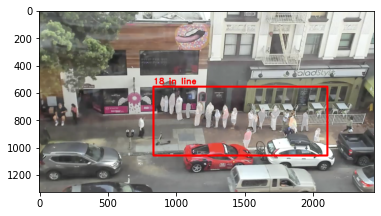

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mrcnn.config
import mrcnn.visualize
import mrcnn.utils
from mrcnn.model import MaskRCNN
from pathlib import Path
from tensorflow import keras


def visualize_detections(image, masks, boxes, class_ids):
    # Create a new solid-black image the same size as the original image
    masked_image = np.zeros(image.shape)

    # Loop over each detected object's mask
    for i in range(masks.shape[2]):
        # If the detected object isn't a person (class_id == 1), skip it
        if class_ids[i] != 1:
            continue

        # Draw the mask for the current object in white
        mask = masks[:, :, i]
        color = (1.0, 1.0, 1.0) # White
        masked_image = mrcnn.visualize.apply_mask(masked_image, mask, color, alpha=1.0)
    plt.imshow(masked_image.astype(np.uint8))
    plt.show()

    # Use Morphological operations (dilate and erode) to find large blobs of people
    kernel = np.ones((5, 5), np.uint8)
    masked_image = cv2.morphologyEx(masked_image, cv2.MORPH_DILATE, kernel, iterations=25)
    plt.imshow(masked_image.astype(np.uint8))
    plt.show()

    # Convert the masked image to pure black and white (1-bit)
    image_bw = cv2.cvtColor(masked_image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    thresh, image_bw = cv2.threshold(image_bw, 220, 255, cv2.THRESH_BINARY)

    # Find the single largest contour area which
    (_, contours, _) = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

    # Draw a line around the largest contour
    #bgr_image = image[:, :, ::-1]
    #cv2.drawContours(bgr_image, contours, 0, (0, 0, 255, 0.5), 10)
    #rgb_image = bgr_image[:, :, ::-1]

    #plt.imshow(rgb_image.astype(np.uint8))
    #plt.show()



    # Find the bounding box of the largest contour
    bounding_x1, bounding_y1, bounding_w, bounding_h = cv2.boundingRect(contours[0])

    # Get the coords of the bottom right corner of the bounding box
    bounding_x2 = bounding_x1 + bounding_w
    bounding_y2 = bounding_y1 + bounding_h

    bgr_image = image[:, :, ::-1]
    font = cv2.FONT_HERSHEY_DUPLEX

    person_count = 0

    # Loop over each detected person
    for i in range(boxes.shape[0]):
        # If the detected object isn't a person (class_id == 1), skip it
        if class_ids[i] != 1:
            continue

        # Get the bounding box of the current person
        y1, x1, y2, x2 = boxes[i]

        # Check if this person is inside the overall line's bounding box
        if x1 >= bounding_x1 and x2 <= bounding_x2 and y1 >= bounding_y1 and y2 <= bounding_y2:
            person_count += 1

           # Draw a mask for the current person
            mask = masks[:, :, i]
            color = (1.0, 1.0, 1.0) # White
            image = mrcnn.visualize.apply_mask(image, mask, color, alpha=0.6)

    # Draw a box around the whole line area
    cv2.rectangle(bgr_image, (bounding_x1, bounding_y1), (bounding_x2, bounding_y2), (0, 0, 255), 14)

    # Label the number of people in line
    cv2.putText(bgr_image, f"{person_count} in line", (bounding_x1, bounding_y1-20), font, 2.0, (0, 0, 255), 5)

    # Convert the image back to RGB
    rgb_image = bgr_image[:, :, ::-1]

    # Return the image and the number of people in line
    return person_count, rgb_image.astype(np.uint8)


# Configuration that will be used by the Mask-RCNN library
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class


# Root directory of the project
#ROOT_DIR = Path(".")

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = "/content/Artificial-Intelligence/Mask_RCNN/logs"

# Local path to trained weights file
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
COCO_MODEL_PATH = "mask_rcnn_coco.h5"

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Create a Mask-RCNN model in inference mode
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())

# Load pre-trained model
model.load_weights(COCO_MODEL_PATH, by_name=True)

# Load the image we want to run detection on
#image_path = str(ROOT_DIR / "sample_images" / "line_example.png")
image_path = "/content/Artificial-Intelligence/Mask_RCNN/line_example.png"
image = cv2.imread(image_path)

# Convert the image from BGR color (which OpenCV uses) to RGB color
rgb_image = image[:, :, ::-1]

# Run the image through the model
results = model.detect([rgb_image], verbose=1)

# Visualize results
r = results[0]
people_in_line_count, masked_image = visualize_detections(rgb_image, r['masks'], r['rois'], r['class_ids'])
print(f"Found {people_in_line_count} people in line outside the building")

# Show the result on the screen
plt.imshow(masked_image.astype(np.uint8))
plt.show()
